# How does vulnerability differ over space?

In [1]:
import libpysal
import esda
from splot.esda import lisa_cluster
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import shapely

In [2]:
# Load the prepared data
cities = ['Den Haag', 'Rotterdam', 'Amsterdam']
resolution = '1000'
id_column = f'c28992r{resolution}'
city_shps = {}
weekday_grids = {}
time_step = 4

for city in cities:
    df = pd.read_csv(f'../data/processed/p2000/{city}/spatiotemporal_grid_time_step={time_step}.csv')
    df['geometry'] = df['geometry'].apply(shapely.wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.crs = 'EPSG:28992'
    weekday_grids[city] = gdf
    city_shps[city] = gpd.read_file(f'../data/processed/cbs/wijk_buurt_kaart/{city}/city.json')

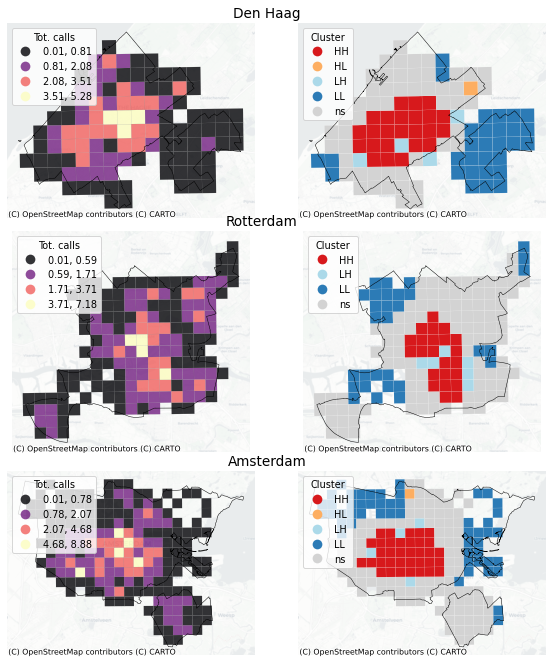

In [3]:
ncols = 2
nrows = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(8, 10))
for i, city in enumerate(cities):
    # Plot the spatial autocorrelation
    weekday_grid = weekday_grids[city].to_crs('EPSG:3857')
    w = libpysal.weights.KNN.from_dataframe(weekday_grid, k=8)
    local_moran = esda.moran.Moran_Local(weekday_grid['Total'], w)
    lisa_cluster(local_moran, weekday_grid, p=0.1, ax=ax[i, 1], legend=True, legend_kwds={'title': 'Cluster', 'loc': 'upper left'})
    
    city_shp = city_shps[city].to_crs('EPSG:3857')
    city_shp.plot(ax=ax[i, 0], facecolor="none", edgecolor='black', linewidth=0.5, zorder=3)
    
    weekday_grid.plot(column='Total', ax=ax[i, 0], legend=True, cmap='magma', zorder=2, scheme='fisher_jenks', k=4, 
                      legend_kwds={'title': 'Tot. calls', 'loc' : 'upper left'}, alpha=0.8, linewidth=0.1, edgecolor='gray')
    ax[i, 1].axis('off')
    ax[i, 0].axis('off')
    city_shp.plot(ax=ax[i, 1], facecolor="none", edgecolor='black', linewidth=0.5, zorder=3)

    # Position title between two column subplots
    ax[i, 0].set_title(city, x=1.05, y=1, fontsize=14)

    # Add base map with contextily
    ctx.add_basemap(ax[i, 0], source=ctx.providers.CartoDB.Positron, alpha=0.5)
    ctx.add_basemap(ax[i, 1], source=ctx.providers.CartoDB.Positron, alpha=0.5)

# Apply tight layout
fig.tight_layout()

# Remove the space between subplots
fig.subplots_adjust(wspace=0.175, hspace=0)
plt.savefig('../report/figures/fig2.png', dpi=300, bbox_inches='tight')